<a href="https://colab.research.google.com/github/sahanyafernando/My_NLP_Learning/blob/main/Project_01_Public_Responce_Analysis/notebooks/Project_01_Public_Response_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
file_path = '/content/drive/MyDrive/My_NLP_Learning/Public_Response_Analysis/data/nlp_multilingual_policy_dataset.csv'


In [7]:
import pandas as pd

# Load the dataset
df = pd.read_csv(file_path)

print("DataFrame Head:")
print(df.head())

print("\nDataFrame Info:")
df.info()

print("\nDataFrame Descriptive Statistics:")
print(df.describe())

DataFrame Head:
   post_id                               user_id  platform language  \
0  POST001  72ff5d2a-386e-4be0-ab65-a6a48b8148f6  Facebook       en   
1  POST002  562b0f79-c374-49ee-b50b-ea63371ecd7b    Reddit       en   
2  POST003  ddd1dfb2-3b98-4ef8-9af6-1a26146d3f31    Reddit       en   
3  POST004  fd5166e6-451b-4cf3-a123-fdf77656af72   Twitter       es   
4  POST005  757750a9-a491-40b2-aa1f-ca65e27a984d  Facebook       en   

             timestamp                  region  \
0  2025-05-05 03:56:41                 Myanmar   
1  2025-02-24 00:27:45  Bosnia and Herzegovina   
2  2025-01-19 00:13:37                 Bolivia   
3  2025-03-15 19:30:59              Uzbekistan   
4  2025-05-05 06:36:54                Cambodia   

                                                text              topic  \
0  Agent every development say quality throughout...  healthcare reform   
1  Serve civil institution everyone. #publictrans...   public transport   
2  Benefit suggest page souther

## Text Preprocessing

In [8]:
import re
import unicodedata
import nltk
from collections import Counter

# Download NLTK stopwords for relevant languages if not already downloaded
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
from nltk.corpus import stopwords

def preprocess_text(text, language):
    # Convert to lowercase
    text = text.lower()

    # Normalize Unicode characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Keep only letters and spaces

    # Tokenize the cleaned text
    tokens = text.split()

    # Remove stopwords specific to the given language
    # Map dataset languages to NLTK stopword languages
    nltk_lang_map = {
        'en': 'english',
        'es': 'spanish',
        'fr': 'french',
        'de': 'german',
        'pt': 'portuguese'
    }

    lang_for_nltk = nltk_lang_map.get(language)

    if lang_for_nltk and lang_for_nltk in stopwords.fileids():
        stop_words = set(stopwords.words(lang_for_nltk))
        tokens = [word for word in tokens if word not in stop_words]

    # Return the list of preprocessed tokens
    return tokens

print("Preprocessing function 'preprocess_text' defined.")

Preprocessing function 'preprocess_text' defined.


In [10]:
df['cleaned_tokens'] = df.apply(lambda row: preprocess_text(row['text'], row['language']), axis=1)
print("Added 'cleaned_tokens' column to DataFrame.")
print("Displaying head of DataFrame with new 'cleaned_tokens' column:")
print(df[['text', 'language', 'cleaned_tokens']].head())

Added 'cleaned_tokens' column to DataFrame.
Displaying head of DataFrame with new 'cleaned_tokens' column:
                                                text language  \
0  Agent every development say quality throughout...       en   
1  Serve civil institution everyone. #publictrans...       en   
2  Benefit suggest page southern role movie win h...       en   
3  Law street class great prove reduce raise auth...       es   
4  Detail food shoulder argue start source husban...       en   

                                      cleaned_tokens  
0  [agent, every, development, say, quality, thro...  
1  [serve, civil, institution, everyone, publictr...  
2  [benefit, suggest, page, southern, role, movie...  
3  [law, street, class, great, prove, reduce, rai...  
4  [detail, food, shoulder, argue, start, source,...  


### display the top 20 most frequent words for each language

In [11]:
N = 20 # Number of top words to display

for lang in df['language'].unique():
    print(f"\nTop {N} words for language: {lang}")
    # Filter DataFrame for the current language and flatten the list of tokens
    all_tokens_for_lang = [token for sublist in df[df['language'] == lang]['cleaned_tokens'].tolist() for token in sublist]

    # Calculate word frequency
    word_counts = Counter(all_tokens_for_lang)

    # Display top N words
    for word, count in word_counts.most_common(N):
        print(f"{word}: {count}")


Top 20 words for language: en
healthcarereform: 8
educationpolicy: 5
economicrelief: 5
ago: 3
publictransport: 3
stop: 3
husband: 3
agent: 2
say: 2
everyone: 2
southern: 2
animal: 2
food: 2
police: 2
check: 2
upon: 2
around: 2
seek: 2
add: 2
ever: 2

Top 20 words for language: es
economicrelief: 5
publictransport: 4
law: 3
environmentallaws: 3
choice: 3
class: 2
prove: 2
author: 2
move: 2
once: 2
human: 2
church: 2
never: 2
billion: 2
decision: 2
reach: 2
wonder: 2
educationpolicy: 2
medical: 2
boy: 2

Top 20 words for language: fr
economicrelief: 7
publictransport: 6
environmentallaws: 5
his: 4
healthcarereform: 4
educationpolicy: 4
let: 4
current: 4
network: 3
boy: 3
list: 3
even: 3
also: 3
between: 3
place: 3
others: 2
quite: 2
those: 2
seem: 2
fall: 2

Top 20 words for language: hi
economicrelief: 6
educationpolicy: 4
healthcarereform: 4
lead: 3
increase: 3
environmentallaws: 3
campaign: 2
enter: 2
find: 2
practice: 2
walk: 2
bank: 2
store: 2
itself: 2
everybody: 2
so: 2
various: 

### Build term-document feature matrices using One-Hot Encoding, Bag-of-Words (BoW), and TF-IDF for the preprocessed text data.

In [12]:
df['preprocessed_text_string'] = df['cleaned_tokens'].apply(lambda tokens: ' '.join(tokens))
print("Added 'preprocessed_text_string' column to DataFrame.")
print("Displaying head of DataFrame with new 'preprocessed_text_string' column:")
print(df[['text', 'language', 'cleaned_tokens', 'preprocessed_text_string']].head())

Added 'preprocessed_text_string' column to DataFrame.
Displaying head of DataFrame with new 'preprocessed_text_string' column:
                                                text language  \
0  Agent every development say quality throughout...       en   
1  Serve civil institution everyone. #publictrans...       en   
2  Benefit suggest page southern role movie win h...       en   
3  Law street class great prove reduce raise auth...       es   
4  Detail food shoulder argue start source husban...       en   

                                      cleaned_tokens  \
0  [agent, every, development, say, quality, thro...   
1  [serve, civil, institution, everyone, publictr...   
2  [benefit, suggest, page, southern, role, movie...   
3  [law, street, class, great, prove, reduce, rai...   
4  [detail, food, shoulder, argue, start, source,...   

                            preprocessed_text_string  
0  agent every development say quality throughout...  
1   serve civil institution everyon

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

# For One-Hot Encoding:
# Initialize a CountVectorizer object with binary=True.
one_hot_vectorizer = CountVectorizer(binary=True)

# Fit and transform the preprocessed_text_string column.
one_hot_matrix = one_hot_vectorizer.fit_transform(df['preprocessed_text_string'])

# Print the shape of the one_hot_matrix.
print("Shape of One-Hot Encoded matrix:", one_hot_matrix.shape)


Shape of One-Hot Encoded matrix: (100, 745)


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# For TF-IDF:
# Initialize a TfidfVectorizer object.
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the preprocessed_text_string column.
tfidf_matrix = tfidf_vectorizer.fit_transform(df['preprocessed_text_string'])

# Print the shape of the tfidf_matrix.
print("Shape of TF-IDF matrix:", tfidf_matrix.shape)

Shape of TF-IDF matrix: (100, 745)


In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize a CountVectorizer object with ngram_range=(2, 2) for bigrams
cooccurrence_vectorizer = CountVectorizer(ngram_range=(2, 2))

# Fit and transform the preprocessed_text_string column
cooccurrence_matrix = cooccurrence_vectorizer.fit_transform(df['preprocessed_text_string'])

# Print the shape of the resulting co-occurrence matrix
print("Shape of Word Co-occurrence Matrix (Bigrams):")
print(cooccurrence_matrix.shape)

Shape of Word Co-occurrence Matrix (Bigrams):
(100, 1361)


In [16]:
from sklearn.feature_extraction.text import CountVectorizer

# For Bag-of-Words (BoW):
# Initialize a CountVectorizer object (default counts word frequency).
bow_vectorizer = CountVectorizer()

# Fit and transform the preprocessed_text_string column.
bow_matrix = bow_vectorizer.fit_transform(df['preprocessed_text_string'])

# Print the shape of the bow_matrix.
print("Shape of Bag-of-Words matrix:", bow_matrix.shape)

Shape of Bag-of-Words matrix: (100, 745)


### Create Co-occurrence Network Graph

In [17]:
import networkx as nx

# Retrieve the list of bigram feature names
feature_names = cooccurrence_vectorizer.get_feature_names_out()

# Calculate the sum of occurrences for each bigram
# Convert to dense array for easier iteration
bigram_counts = cooccurrence_matrix.sum(axis=0).A1

# Create an empty networkx graph object
G = nx.Graph()

# Iterate through bigram feature names and their corresponding total counts to add edges
for i, bigram in enumerate(feature_names):
    # Split the bigram string into its two individual words
    word1, word2 = bigram.split(' ')
    # Get the count for this bigram
    weight = bigram_counts[i]
    # Add an edge between these two words with the weight attribute
    if weight > 0: # Only add edges for bigrams that actually appeared
        G.add_edge(word1, word2, weight=weight)

# Print the number of nodes and edges in the created graph
print(f"Number of nodes in the co-occurrence graph: {G.number_of_nodes()}")
print(f"Number of edges in the co-occurrence graph: {G.number_of_edges()}")

Number of nodes in the co-occurrence graph: 745
Number of edges in the co-occurrence graph: 1358


### Visualize Co-occurrence Network

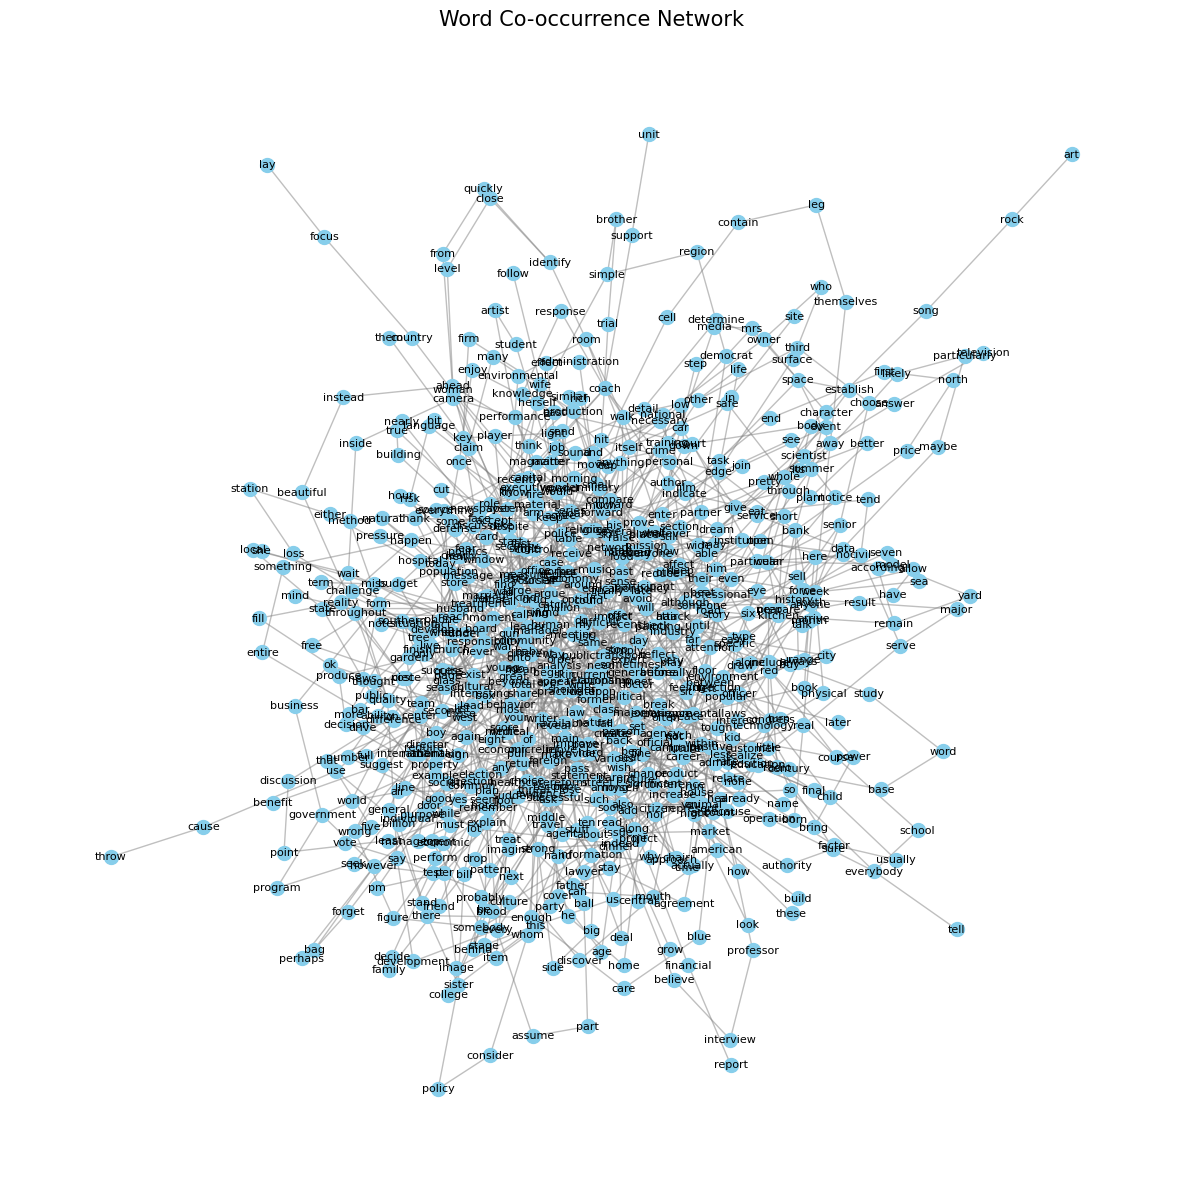

In [18]:
import matplotlib.pyplot as plt

# Initialize a figure and an axes for plotting the graph.
plt.figure(figsize=(15, 15))

# Choose a layout for the graph visualization
# Use a spring layout for better visualization of clusters
pos = nx.spring_layout(G, k=0.1, iterations=50) # k adjusts node repulsion

# Draw the nodes of the graph
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=100)

# Draw the edges of the graph. Adjust edge width based on 'weight' attribute.
edges = G.edges(data=True)
weights = [d['weight'] for u, v, d in edges]
nx.draw_networkx_edges(G, pos, width=weights, edge_color='gray', alpha=0.5)

# Draw the node labels. Consider adjusting font size for readability.
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

# Remove the axes to clean up the plot
plt.axis('off')

# Add a title to the plot
plt.title('Word Co-occurrence Network', size=15)

# Display the plot
plt.show()

### Data Analysis Key Findings

- A TF-IDF matrix was successfully generated with a shape of (100, 745), indicating 100 documents and 745 unique terms.
- A word co-occurrence matrix for bigrams was constructed, resulting in a matrix of shape (100, 1361), representing 100 documents and 1361 unique bigrams.
- A Bag-of-Words matrix was also generated, with a shape of (100, 745), aligning with the number of unique terms found in the TF-IDF analysis.
- The co-occurrence matrix was converted into a networkx graph, which contains 745 nodes (unique words) and 1358 edges (bigram co-occurrences).
- The word co-occurrence network was successfully visualized using matplotlib and networkx, displaying relationships between co-occurring words, with edge widths adjusted by their co-occurrence frequency (weight).

## Save preprocessing artifacts
Run this cell after the preprocessing steps to enable downstream notebooks to reload the prepared data.

In [ ]:
import pickle, pathlib
# Update this path if your project lives elsewhere in Drive
artifacts_root = pathlib.Path("/content/drive/MyDrive/My_NLP_Learning/Public_Response_Analysis")
artifacts_dir = artifacts_root / "artifacts"
artifacts_dir.mkdir(exist_ok=True)
with open(artifacts_dir / "preprocessing_outputs.pkl", "wb") as f:
    pickle.dump({
        "df": df,
        "one_hot_vectorizer": one_hot_vectorizer,
        "one_hot_matrix": one_hot_matrix,
        "bow_vectorizer": bow_vectorizer,
        "bow_matrix": bow_matrix,
        "tfidf_vectorizer": tfidf_vectorizer,
        "tfidf_matrix": tfidf_matrix,
        "cooccurrence_vectorizer": cooccurrence_vectorizer,
        "cooccurrence_matrix": cooccurrence_matrix
    }, f)
print("Saved preprocessing outputs to artifacts/preprocessing_outputs.pkl")
